# **Import Needed Modules**

In [1]:
# import system libs 
import os
import time
import glob
import shutil

# import data handling tools 
import cv2
import PIL
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
import tensorflow.image as tfi
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Conv2D,  MaxPool2D, UpSampling2D, concatenate, Activation
from tensorflow.keras.layers import Layer, Input, Add, Multiply, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


# **Create Needed Functions**

### **Function to create data**

In [2]:
def create_data(data_dir):
    image_paths = []
    mask_paths = []
    classes = sorted(os.listdir(data_dir))
    
    single_mask_paths = sorted([sorted(glob.glob(data_dir + name + "/*mask.png")) for name in classes])
    double_mask_paths = sorted([sorted(glob.glob(data_dir + name + "/*mask_1.png")) for name in classes])
    
    for class_path in single_mask_paths:
        for path in class_path:
            img_path = path.replace('_mask', '')
            image_paths.append(img_path)
            mask_paths.append(path)
    
    return image_paths, mask_paths

### **Functions to read images**

In [3]:
# function to read an image
def load_image(image, SIZE):
    return np.round(tfi.resize(img_to_array(load_img(image)) / 255., (SIZE, SIZE)), 4)

# function to read multiple images
def load_images(image_paths, SIZE, mask=False, trim=None):
    if trim is not None:
        image_paths = image_paths[:trim]
    
    if mask:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 1))
    else:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 3))
    
    for i, image in enumerate(image_paths):
        img = load_image(image, SIZE)
        if mask:
            images[i] = img[:, :, :1]
        else:
            images[i] = img
    
    return images

### **Function to display data sample**

In [4]:
def show_image(image, title=None, cmap=None, alpha=1):
    plt.imshow(image, cmap=cmap, alpha=alpha)
    if title is not None:
        plt.title(title)
    plt.axis('off')

def show_mask(image, mask, cmap=None, alpha=0.4):
    plt.imshow(image)
    plt.imshow(tf.squeeze(mask), cmap=cmap, alpha=alpha)
    plt.axis('off')

def show_images(imgs, msks):
    plt.figure(figsize=(13,8))
    
    for i in range(15):
        plt.subplot(3,5,i+1)
        id = np.random.randint(len(imgs))
        show_mask(imgs[id], msks[id], cmap='binary')
    
    plt.tight_layout()
    plt.show()

### **Encoder**

In [5]:
class EncoderBlock(Layer):

    def __init__(self, filters, rate, pooling=True, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate
        self.pooling = pooling

        self.c1 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.drop = Dropout(rate)
        self.c2 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.pool = MaxPool2D()

    def call(self, X):
        x = self.c1(X)
        x = self.drop(x)
        x = self.c2(x)
        if self.pooling:
            y = self.pool(x)
            return y, x
        else:
            return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            'rate':self.rate,
            'pooling':self.pooling
        }

### **Decoder**

In [6]:
class DecoderBlock(Layer):

    def __init__(self, filters, rate, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate

        self.up = UpSampling2D()
        self.net = EncoderBlock(filters, rate, pooling=False)

    def call(self, X):
        X, skip_X = X
        x = self.up(X)
        c_ = concatenate([x, skip_X])
        x = self.net(c_)
        return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            'rate':self.rate,
        }

### **AttentionGate**

In [7]:
class AttentionGate(Layer):

    def __init__(self, filters, bn, **kwargs):
        super(AttentionGate, self).__init__(**kwargs)

        self.filters = filters
        self.bn = bn

        self.normal = Conv2D(filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
        self.down = Conv2D(filters, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer='he_normal')
        self.learn = Conv2D(1, kernel_size=1, padding='same', activation='sigmoid')
        self.resample = UpSampling2D()
        self.BN = BatchNormalization()

    def call(self, X):
        X, skip_X = X

        x = self.normal(X)
        skip = self.down(skip_X)
        x = Add()([x, skip])
        x = self.learn(x)
        x = self.resample(x)
        f = Multiply()([x, skip_X])
        if self.bn:
            return self.BN(f)
        else:
            return f
        # return f

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            "bn":self.bn
        }

### **Callbacks**

In [8]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch # save this value to restore if restarting training

        # callback variables
        self.best_epoch = 1   # epoch with the lowest loss
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initial learning rate and save it
        self.highest_tracc = 0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf # set lowest validation loss to infinity initially
        self.best_weights = self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights = self.model.get_weights()   # save initial weights if they have to get restored

    # Define a function that will run when train begins
    def on_train_begin(self, logs= None):
        msg = 'Do you want model asks you to halt the training [y/n] ?'
        print(msg)
        ans = input('')
        if ans == 'Y' or ans == 'y':
            self.ask_permission = 1
        elif ans == 'N' or ans == 'n':
            self.ask_permission = 0
        
        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'Duration')
        print(msg)
        self.start_time = time.time()


    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)

        # set the weights of the model to the best weights
        self.model.set_weights(self.best_weights) 


    def on_train_batch_end(self, batch, logs= None):
        # get batch accuracy and loss
        acc = logs.get('accuracy') * 100 
        loss = logs.get('loss')
        
        # prints over on the same line to show running batch count
        msg = '{0:20s}processing batch {1:}  -   accuracy=  {2:5.3f}   -   loss: {3:8.5f}'.format(' ', str(batch),  acc, loss)
        print(msg, '\r', end= '') 


    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()


    # Define method runs on the end of each epoch
    def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        acc = logs.get('accuracy')  # get training accuracy
        v_acc = logs.get('val_accuracy')  # get validation accuracy
        loss = logs.get('loss')  # get training loss for this epoch
        v_loss = logs.get('val_loss')  # get the validation loss for this epoch

        print('\n')
        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{duration:^8.2f}'
        print(msg)

        if self.ask_epoch != None and self.ask_permission != 0:
            if epoch + 1 >= self.ask_epoch:
                msg = 'enter H to halt training or an integer for number of epochs to run then ask again'
                print(msg)
                ans = input('')
                if ans == 'H' or ans == 'h':
                    msg = f'training has been halted at epoch {epoch + 1} due to user input'
                    print(msg)
                    self.model.stop_training = True # stop training
                else:
                    try:
                        ans = int(ans)
                        self.ask_epoch += ans
                        msg = f' training will continue until epoch ' + str(self.ask_epoch)
                        print(msg)
                        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'Duration')
                        print(msg)
                    except:
                        print('Invalid')

### **Function to plot training history**

In [9]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

# **Model Structure**

### **Get Data**

2023-01-26 22:05:37.352288: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 22:05:37.447220: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 22:05:37.448064: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 22:05:37.450232: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

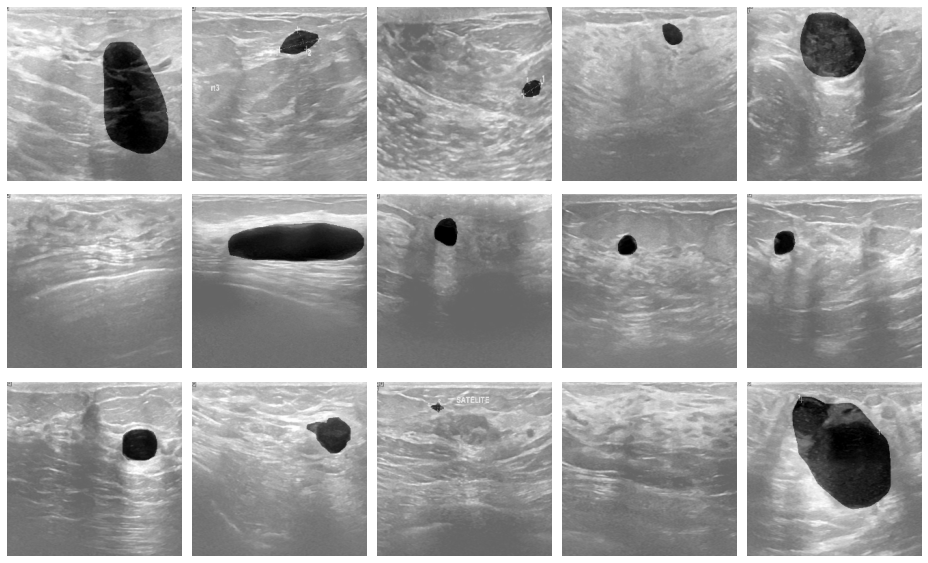

In [10]:
SIZE = 256

# get data
data_dir = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/'
image_paths, mask_paths = create_data(data_dir)

# load images and masks
imgs = load_images(image_paths, SIZE)
msks = load_images(mask_paths, SIZE, mask=True)

# show sample
show_images(imgs, msks)

### **Create Model**

In [11]:
# Inputs
input_layer = Input(shape= imgs.shape[-3:])

# Encoder
p1, c1 = EncoderBlock(32, 0.1, name="Encoder1")(input_layer)
p2, c2 = EncoderBlock(64, 0.1, name="Encoder2")(p1)
p3, c3 = EncoderBlock(128, 0.2, name="Encoder3")(p2)
p4, c4 = EncoderBlock(256, 0.2, name="Encoder4")(p3)

# Encoding
encoding = EncoderBlock(512, 0.3, pooling=False, name="Encoding")(p4)

# Attention + Decoder
a1 = AttentionGate(256, bn=True, name="Attention1")([encoding, c4])
d1 = DecoderBlock(256, 0.2, name="Decoder1")([encoding, a1])

a2 = AttentionGate(128, bn=True, name="Attention2")([d1, c3])
d2 = DecoderBlock(128, 0.2, name="Decoder2")([d1, a2])

a3 = AttentionGate(64, bn=True, name="Attention3")([d2, c2])
d3 = DecoderBlock(64, 0.1, name="Decoder3")([d2, a3])

a4 = AttentionGate(32, bn=True, name="Attention4")([d3, c1])
d4 = DecoderBlock(32,0.1, name="Decoder4")([d3, a4])

# Output 
output_layer = Conv2D(1, kernel_size=1, activation='sigmoid', padding='same')(d4)

# Model
model = Model(inputs= [input_layer], outputs= [output_layer])

# Compile
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Encoder1 (EncoderBlock)         ((None, 128, 128, 32 10144       input_1[0][0]                    
__________________________________________________________________________________________________
Encoder2 (EncoderBlock)         ((None, 64, 64, 64), 55424       Encoder1[0][0]                   
__________________________________________________________________________________________________
Encoder3 (EncoderBlock)         ((None, 32, 32, 128) 221440      Encoder2[0][0]                   
______________________________________________________________________________________________

In [12]:
batch_size = 40     # set batch size for training
epochs = 40         # number of all epochs in training
ask_epoch = 5		    # number of epochs to run before asking if you want to halt training

callbacks = [MyCallback(model= model, epochs= epochs, ask_epoch= ask_epoch )]

### **Train Model**

In [13]:
# Config Training
SPE = len(imgs)//batch_size

# Training
history = model.fit(
    imgs, msks,
    validation_split=0.2,
    epochs=epochs,
    verbose=0,
    steps_per_epoch=SPE,
    batch_size=batch_size,
    callbacks=callbacks    
)

Do you want model asks you to halt the training [y/n] ?


 y


 Epoch     Loss   Accuracy  V_loss    V_acc  Duration


2023-01-26 22:06:10.549115: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-26 22:06:13.626131: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
2023-01-26 22:06:23.666759: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.39GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


                    processing batch 18  -   accuracy=  86.191   -   loss:  0.42763 

 1 /40     0.428   86.191   0.49528  98.134   34.60  
                    processing batch 18  -   accuracy=  90.755   -   loss:  0.27166 

 2 /40     0.272   90.755   0.48569  98.134   10.74  
                    processing batch 18  -   accuracy=  91.683   -   loss:  0.22660 

 3 /40     0.227   91.683   0.47172  98.134   10.73  
                    processing batch 18  -   accuracy=  91.293   -   loss:  0.22709 

 4 /40     0.227   91.293   0.45605  98.134   10.72  
                    processing batch 18  -   accuracy=  92.238   -   loss:  0.20863 

 5 /40     0.209   92.238   0.43298  98.133   10.76  
enter H to halt training or an integer for number of epochs to run then ask again


 20


 training will continue until epoch 25
 Epoch     Loss   Accuracy  V_loss    V_acc  Duration
                    processing batch 18  -   accuracy=  91.989   -   loss:  0.20748 

 6 /40     0.207   91.989   0.41847  98.139   10.49  
                    processing batch 18  -   accuracy=  92.945   -   loss:  0.18792 

 7 /40     0.188   92.945   0.32619  98.136   10.71  
                    processing batch 18  -   accuracy=  93.623   -   loss:  0.17054 

 8 /40     0.171   93.623   0.30088  98.138   10.73  
                    processing batch 18  -   accuracy=  93.799   -   loss:  0.17077 

 9 /40     0.171   93.799   0.30808  98.138   10.73  
                    processing batch 18  -   accuracy=  94.037   -   loss:  0.16208 

10 /40     0.162   94.037   0.23845  98.140   10.74  
                    processing batch 18  -   accuracy=  94.004   -   loss:  0.16431 

11 /40     0.164   94.004   0.15350  98.146   10.53  
                    processing batch 18  -   accuracy=  94.568   - 

 15


 training will continue until epoch 40
 Epoch     Loss   Accuracy  V_loss    V_acc  Duration
                    processing batch 18  -   accuracy=  96.188   -   loss:  0.09549 

26 /40     0.095   96.188   0.05914  98.509   10.73  
                    processing batch 18  -   accuracy=  96.462   -   loss:  0.08921 

27 /40     0.089   96.462   0.06264  98.394   10.51  
                    processing batch 18  -   accuracy=  96.466   -   loss:  0.08693 

28 /40     0.087   96.466   0.06611  98.513   10.72  
                    processing batch 18  -   accuracy=  96.554   -   loss:  0.08560 

29 /40     0.086   96.554   0.06335  98.430   10.70  
                    processing batch 18  -   accuracy=  96.590   -   loss:  0.08332 

30 /40     0.083   96.590   0.06521  98.344   10.72  
                    processing batch 18  -   accuracy=  96.680   -   loss:  0.08221 

31 /40     0.082   96.680   0.06722  98.150   10.71  
                    processing batch 18  -   accuracy=  97.005   - 

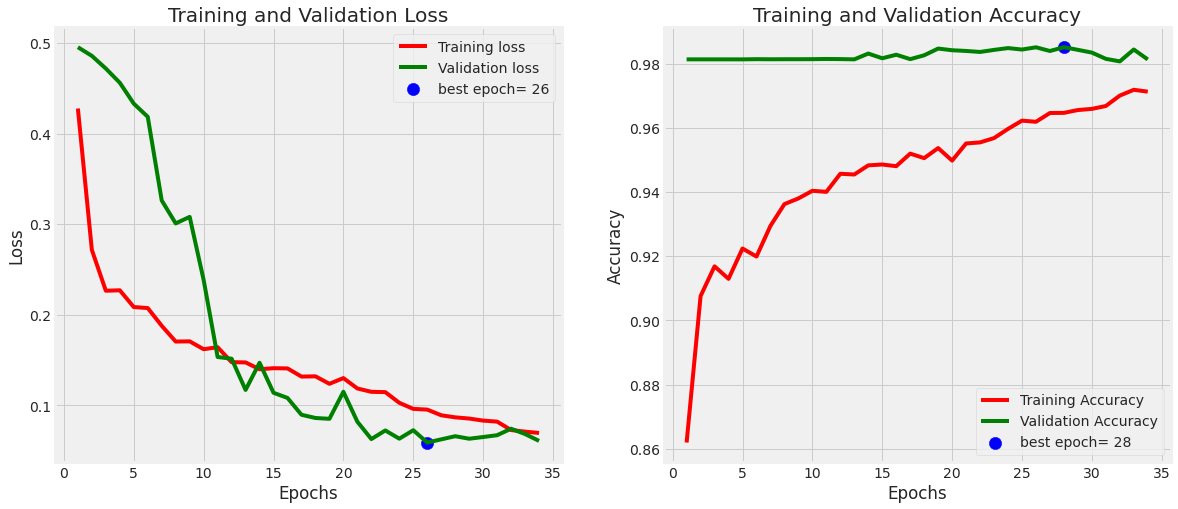

In [14]:
plot_training(history)

# **Evaluation**

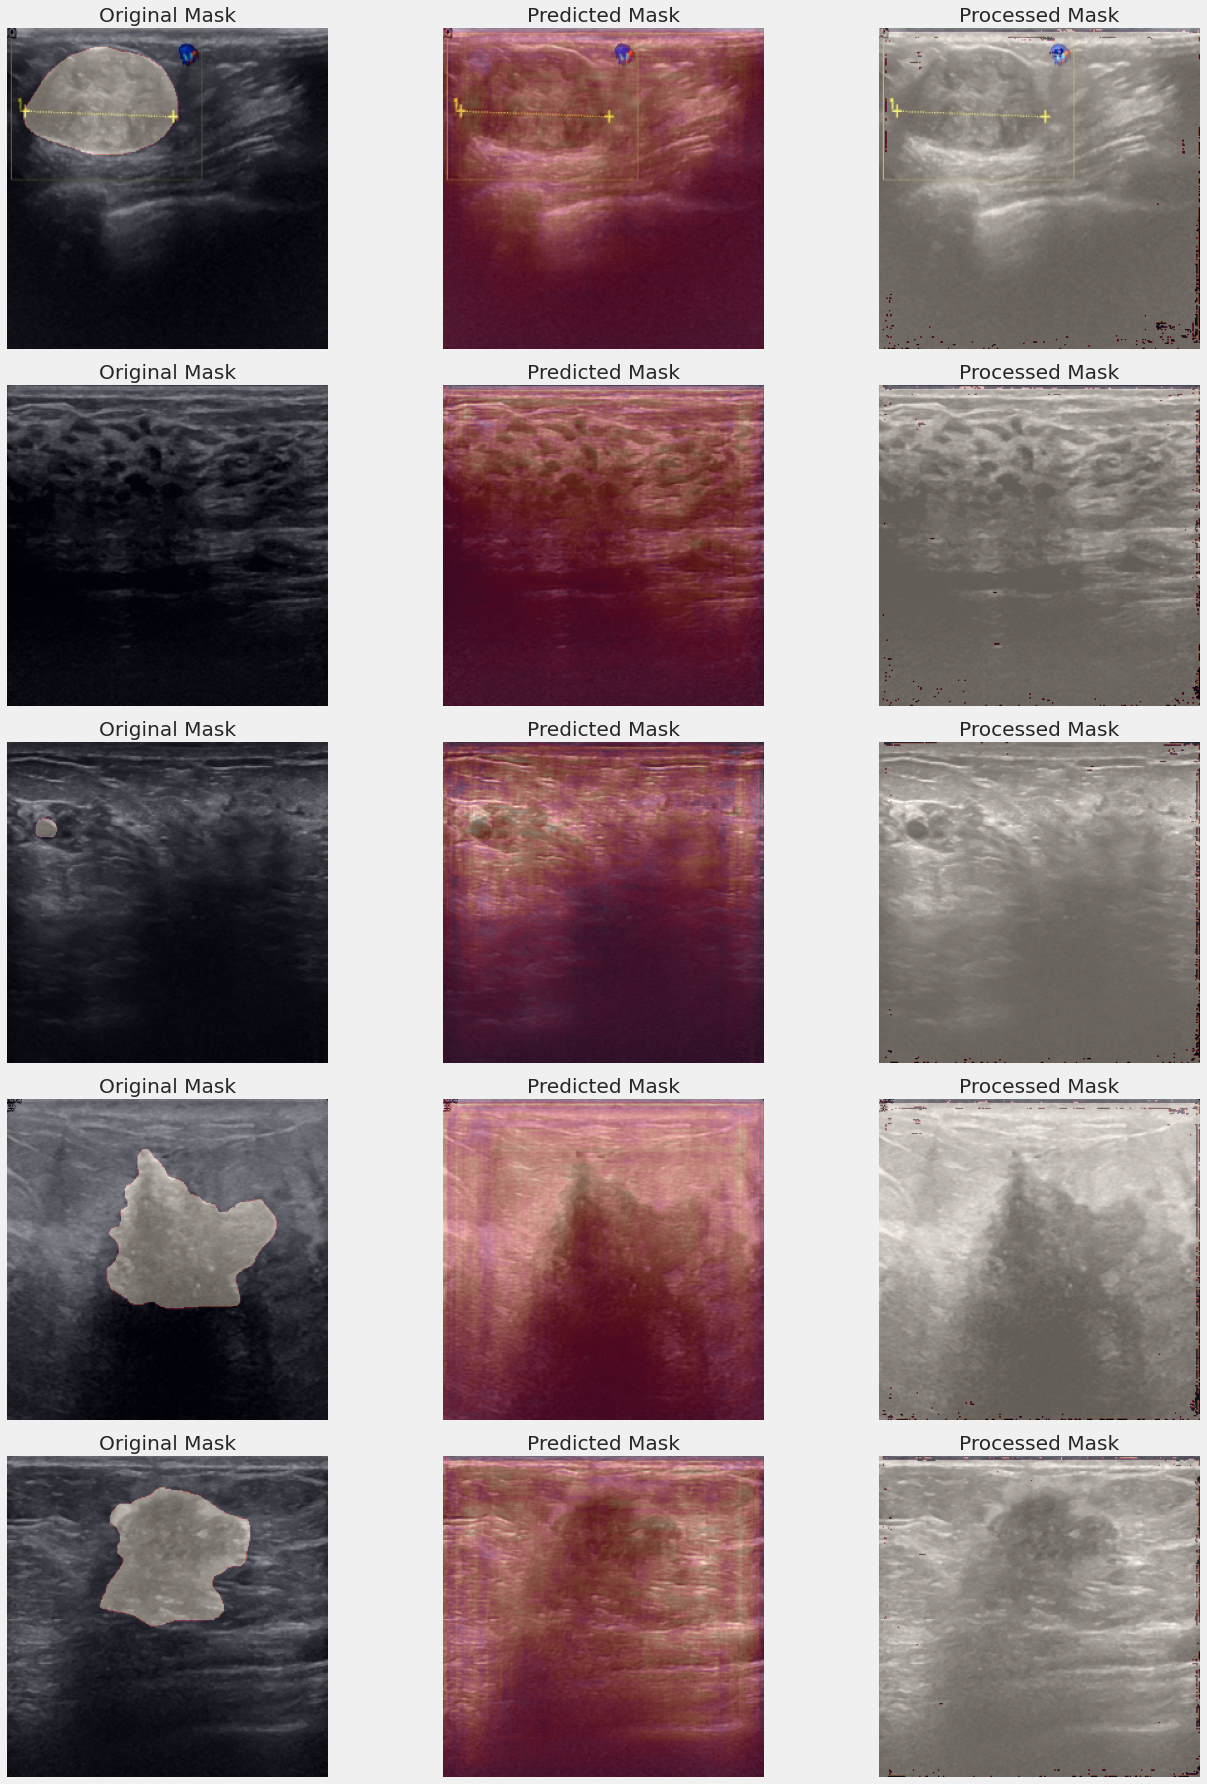

In [15]:
plt.figure(figsize=(20,25))
n=0
for i in range(1,(5*3)+1):
    plt.subplot(5,3,i)
    if n==0:
        id = np.random.randint(len(imgs))
        image = imgs[id]
        mask = msks[id]
        pred_mask = model.predict(image[np.newaxis,...])

        plt.title("Original Mask")
        show_mask(image, mask)
        n+=1
    elif n==1:
        plt.title("Predicted Mask")
        show_mask(image, pred_mask)
        n+=1
    elif n==2:
        pred_mask = (pred_mask>0.5).astype('float')
        plt.title("Processed Mask")
        show_mask(image, pred_mask)
        n=0
plt.tight_layout()
plt.show()

# Thank You..